In [19]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [20]:
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

arxiv_wrapper = ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper = WikipediaAPIWrapper(top_k_results=1,doc_content_CHARS_MAX=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [21]:
tools=[arxiv_tool,wiki_tool,]

In [22]:
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list,add_messages]

In [23]:
from langgraph.graph import StateGraph, START, END
graph_builder = StateGraph(State)

In [24]:
tools=[wiki_tool,arxiv_tool]

In [25]:
import os
from langchain_groq import ChatGroq
groq_api_key=os.environ.get("groq_api_key")

llm =ChatGroq(groq_api_key=groq_api_key)

In [26]:
llm.invoke("Hey").content

"Hello! How can I help you today? If you have any questions about programming, web development, or data science, feel free to ask. I'm here to provide guidance and resources to support your learning journey. 😊"

In [27]:
llm_with_tools=llm.bind_tools(tools)

In [28]:
def chatbot(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node("chatbot",chatbot)
tool_node=ToolNode(tools=tools)

In [29]:
graph_builder.add_node("tools",tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

In [30]:
graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge(START,"chatbot")
graph_builder.add_edge("chatbot",END)

In [31]:
graph=graph_builder.compile(checkpointer=memory)

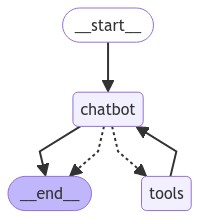

In [32]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [33]:
config = {"configurable": {"thread_id": "1"}}

In [34]:
while True:
  user_input=input()
  if user_input.lower() in ["quit","q"]:
    print("Khatam Tata Bye-bye")
    break
  if user_input:
    # The config is the **second positional argument** to stream() or invoke()!
    events = graph.stream(
        {"messages": [("user", user_input)]}, config, stream_mode="values"
    )
    for event in events:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_8w72)
 Call ID: call_8w72
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: wikipedia

Page: LangChain
Summary: LangChain is a framework designed to simplify the creation of applications using large language models (LLMs). As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


================================== Ai Message ==================================

LangChain is a framework designed to simplify the creation of applications using large language models (LLMs). It is useful for various applications such as document anal

In [35]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content="I'm learning LangGraph. Could you do some research on it for me?", id='0dd59723-2ca7-4233-a461-109ea7d105d3'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8w72', 'function': {'arguments': '{"query":"LangGraph"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 88, 'prompt_tokens': 1440, 'total_tokens': 1528, 'completion_time': 0.141845989, 'prompt_time': 0.071852643, 'queue_time': 0.0009426760000000034, 'total_time': 0.213698632}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7098a65a-3d97-4036-a6f3-0f80ae5b12ee-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'LangGraph'}, 'id': 'call_8w72', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1440, 'output_tokens': 88, 'total_tokens': 1528}), ToolMessage(content="Page: LangChain\nSummary: LangChain is a fra

In [36]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()